In [1]:
import pandas as pd
import joblib
import gpplot
import seaborn as sns

from datasets import external_dataset_list
import target_featurization as ft
from core import (setup_plots,
                  add_xy_line)

In [2]:
setup_plots()

In [3]:
target_model = joblib.load('../models/target_model.pkl')
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')

In [4]:
dataset_activity_list = []
for ds in external_dataset_list:
    if ds.endogenous:
        ds.load_data()
        ds.set_sgrnas()
        dataset_activity = ds.get_sg_df(include_group=True, include_activity=True,
                                        include_pam=False)
        dataset_activity['dataset'] = ds.name
        dataset_activity['genomewide'] = ds.genomewide
        design_df = ds.get_designs()
        dataset_activity = dataset_activity.merge(design_df, how='inner',
                                                  on=['sgRNA Sequence', 'sgRNA Context Sequence'])
        dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df = ft.add_target_columns(dataset_activity_df)  # only necessary for getting transcript bases
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,Input,Quota,Target Taxon,Target Gene ID,...,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes,AA Index,Transcript Base
0,CTGGTCTACCGTGAAGTTCAC,GGATCTGGTCTACCGTGAAGTTCACCTGGGCAAGAC,EEF2,0.413396,Doench2018_SaCas9,False,ENSG00000167658,MAX,9606,ENSG00000167658,...,288,263,1.0,1.0,319,300.0,3.0,Previously skipped due to: Outside Target Wind...,2,ENST00000309311
1,CTGGTCTACCGTGAAGTTCAC,GGATCTGGTCTACCGTGAAGTTCACCTGGGCAAGAC,EEF2,0.685733,Doench2018_SaCas9,False,ENSG00000167658,MAX,9606,ENSG00000167658,...,288,263,1.0,1.0,319,300.0,3.0,Previously skipped due to: Outside Target Wind...,2,ENST00000309311
2,CTGGTCTACCGTGAAGTTCAC,GGATCTGGTCTACCGTGAAGTTCACCTGGGCAAGAC,EEF2,0.700469,Doench2018_SaCas9,False,ENSG00000167658,MAX,9606,ENSG00000167658,...,288,263,1.0,1.0,319,300.0,3.0,Previously skipped due to: Outside Target Wind...,2,ENST00000309311
3,ATGGCGCGGATCTGGTCTACC,CATGATGGCGCGGATCTGGTCTACCGTGAAGTTCAC,EEF2,0.679705,Doench2018_SaCas9,False,ENSG00000167658,MAX,9606,ENSG00000167658,...,188,103,1.0,1.0,102,270.0,3.0,Previously skipped due to: Outside Target Wind...,6,ENST00000309311
4,ATGGCGCGGATCTGGTCTACC,CATGATGGCGCGGATCTGGTCTACCGTGAAGTTCAC,EEF2,0.909176,Doench2018_SaCas9,False,ENSG00000167658,MAX,9606,ENSG00000167658,...,188,103,1.0,1.0,102,270.0,3.0,Previously skipped due to: Outside Target Wind...,6,ENST00000309311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13215,CCTGTGGACTGGAGTATTAAAAC,CTGAGTTACCTGTGGACTGGAGTATTAAAACGCG,DONSON,0.953642,DeWeirdt2020_enCas12a,False,ENSG00000249209,NaN,9606,ENSG00000249209,...,16,218,1.0,1.0,80,142.0,3.0,Previously skipped due to: Outside Target Wind...,173,ENST00000429238
13216,CTTACCAAGAGCATGAGGAATGA,AGAGGTTACTTACCAAGAGCATGAGGAATGAGGT,SLC39A7,0.707006,DeWeirdt2020_enCas12a,False,ENSG00000112473,NaN,9606,ENSG00000112473,...,59,239,1.0,1.0,82,51.0,2.0,Previously skipped due to: Spacing Violation: ...,188,ENST00000374675
13217,TCAGAATTCCGAGAAGGAGTGCG,AGGTGTTATCAGAATTCCGAGAAGGAGTGCGGAA,CARS,0.602564,DeWeirdt2020_enCas12a,False,ENSG00000110619,NaN,9606,ENSG00000110619,...,139,273,1.0,1.0,74,741.0,4.0,Previously skipped due to: Outside Target Wind...,681,ENST00000380525
13218,GGGCGAGGCTTCATTGCAGGCAT,AGTTGTTAGGGCGAGGCTTCATTGCAGGCATTGA,DDX23,0.818182,DeWeirdt2020_enCas12a,False,ENSG00000174243,NaN,9606,ENSG00000174243,...,93,78,1.0,1.0,12,11.0,2.0,Previously skipped due to: Spacing Violation: ...,306,ENST00000308025


In [5]:
transcript_bases = list(dataset_activity_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

## Residuals

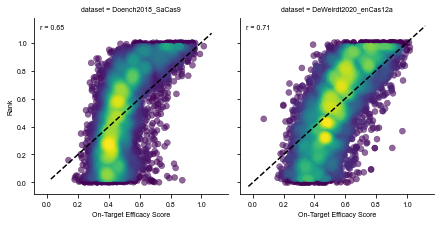

In [6]:
g = sns.FacetGrid(data=dataset_activity_df, col='dataset')
g.map_dataframe(gpplot.point_densityplot, y='sgRNA Activity',
                x='On-Target Efficacy Score')
g.map_dataframe(gpplot.add_correlation, x='On-Target Efficacy Score',
                y='sgRNA Activity', color='black')
g.map(add_xy_line, color='black')
g.set_axis_labels(x_var='On-Target Efficacy Score',
                  y_var='Rank')

In [7]:
dataset_activity_df['Residual Activity'] = (dataset_activity_df['sgRNA Activity'] -
                                            dataset_activity_df['On-Target Efficacy Score'])

## Target Score

In [8]:
target_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
               'Orientation', 'Target Cut %', 'Target Cut Length',
               'Target Transcript']  # Note don't need Transcript Base and AA Index
dataset_activity_df['# Off-Target Tier I Match Bin I Matches'] = pd.to_numeric(dataset_activity_df['# Off-Target Tier I Match Bin I Matches'], errors='coerce')
unique_activity = (dataset_activity_df
                   .loc[dataset_activity_df['# Off-Target Tier I Match Bin I Matches'] == 0,
                        target_cols]
                   .drop_duplicates())
target_feature_df, target_feature_cols = ft.build_target_feature_df(unique_activity,
                                                                    features=['position', 'aa',
                                                                              'domain', 'conservation'],
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df,
                                                                    id_cols=['sgRNA Context Sequence', 'Target Cut Length',
                                                                             'Target Transcript', 'Orientation'])
X_target = target_feature_df[target_feature_cols]
unique_activity['Target Score'] = target_model.predict(X_target)
dataset_activity_df = (dataset_activity_df.merge(unique_activity, how='left',
                                                 on=target_cols))

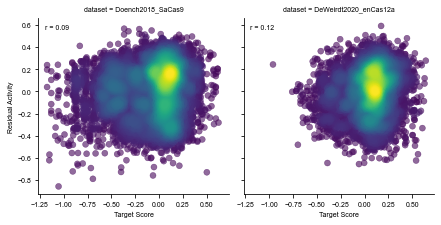

In [9]:
g = sns.FacetGrid(data=dataset_activity_df[~dataset_activity_df['Target Score'].isna()], col='dataset')
g.map_dataframe(gpplot.point_densityplot, x='Target Score',
                y='Residual Activity')
g.map_dataframe(gpplot.add_correlation, x='Target Score',
                y='Residual Activity', color='black')
g.set_axis_labels(x_var='Target Score',
                  y_var='Residual Activity')

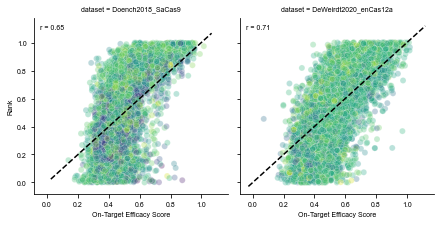

In [10]:
g = sns.FacetGrid(data=dataset_activity_df, col='dataset')
g.map_dataframe(sns.scatterplot, y='sgRNA Activity',
                x='On-Target Efficacy Score', hue='Target Score',
                palette='viridis', alpha=0.3, marker='o')
g.map_dataframe(gpplot.add_correlation, x='On-Target Efficacy Score',
                y='sgRNA Activity', color='black')
g.map(add_xy_line, color='black')
g.set_axis_labels(x_var='On-Target Efficacy Score',
                  y_var='Rank')

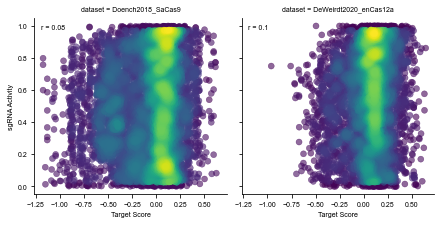

In [11]:
g = sns.FacetGrid(data=dataset_activity_df[~dataset_activity_df['Target Score'].isna()], col='dataset')
g.map_dataframe(gpplot.point_densityplot, x='Target Score',
                y='sgRNA Activity')
g.map_dataframe(gpplot.add_correlation, x='Target Score',
                y='sgRNA Activity', color='black')
g.set_axis_labels(x_var='Target Score',
                  y_var='sgRNA Activity')